In [18]:
import cupy as cp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import rism
from rism.core import FFTGrid, Solvent, Matrix
from rism.solver import RISMPolarSolventDIIS1DSolver
from rism.io import MatrixWriter, MatrixParser
from rism.unit import *

In [14]:
def visualize(grid, matrix, site_list):
    num_sites = len(site_list)
    r = grid.r.get()
    fig, ax = plt.subplots(1, 1, figsize=[16, 9])
    for i in range(num_sites - 1):
        for j in range(i, num_sites - 1):
            ax.plot(
                r,
                matrix[i, j].get(),
                ".-",
                label="%s-%s" % (site_list[i], site_list[j]),
            )
            ax.legend()
    fig.tight_layout()
    plt.show()

In [15]:
def get_solvent() -> Solvent:
    solvent = Solvent()
    solvent.add_particle(name="o", particle_type="o")
    solvent.add_particle(name="h1", particle_type="h")
    solvent.add_particle(name="h2", particle_type="h")
    solvent.add_bond("o", "h1", 0.9572)
    solvent.add_bond("o", "h2", 0.9572)
    solvent.add_bond("h1", "h2", 1.5139)
    return solvent

[[0.     0.9572 0.9572]
 [0.9572 0.     1.5139]
 [0.9572 1.5139 0.    ]]
(2048,)
Iteration 10, Residual 5.274e-01
Iteration 20, Residual 3.353e+00
Iteration 30, Residual 6.139e-01
Iteration 40, Residual 6.846e-01
Iteration 50, Residual 7.305e+00
Iteration 60, Residual 4.433e+00
Iteration 70, Residual 1.936e-01
Iteration 80, Residual 2.477e-01
Iteration 90, Residual 4.051e-02
Iteration 100, Residual 2.055e-04
Iteration 110, Residual 7.315e-06
Iteration 120, Residual 6.486e-07
Stop iterate at 120 steps, residual 6.486e-07 smaller than tolerance 1.000e-06
Run solve() for 0.9223902225494385 s


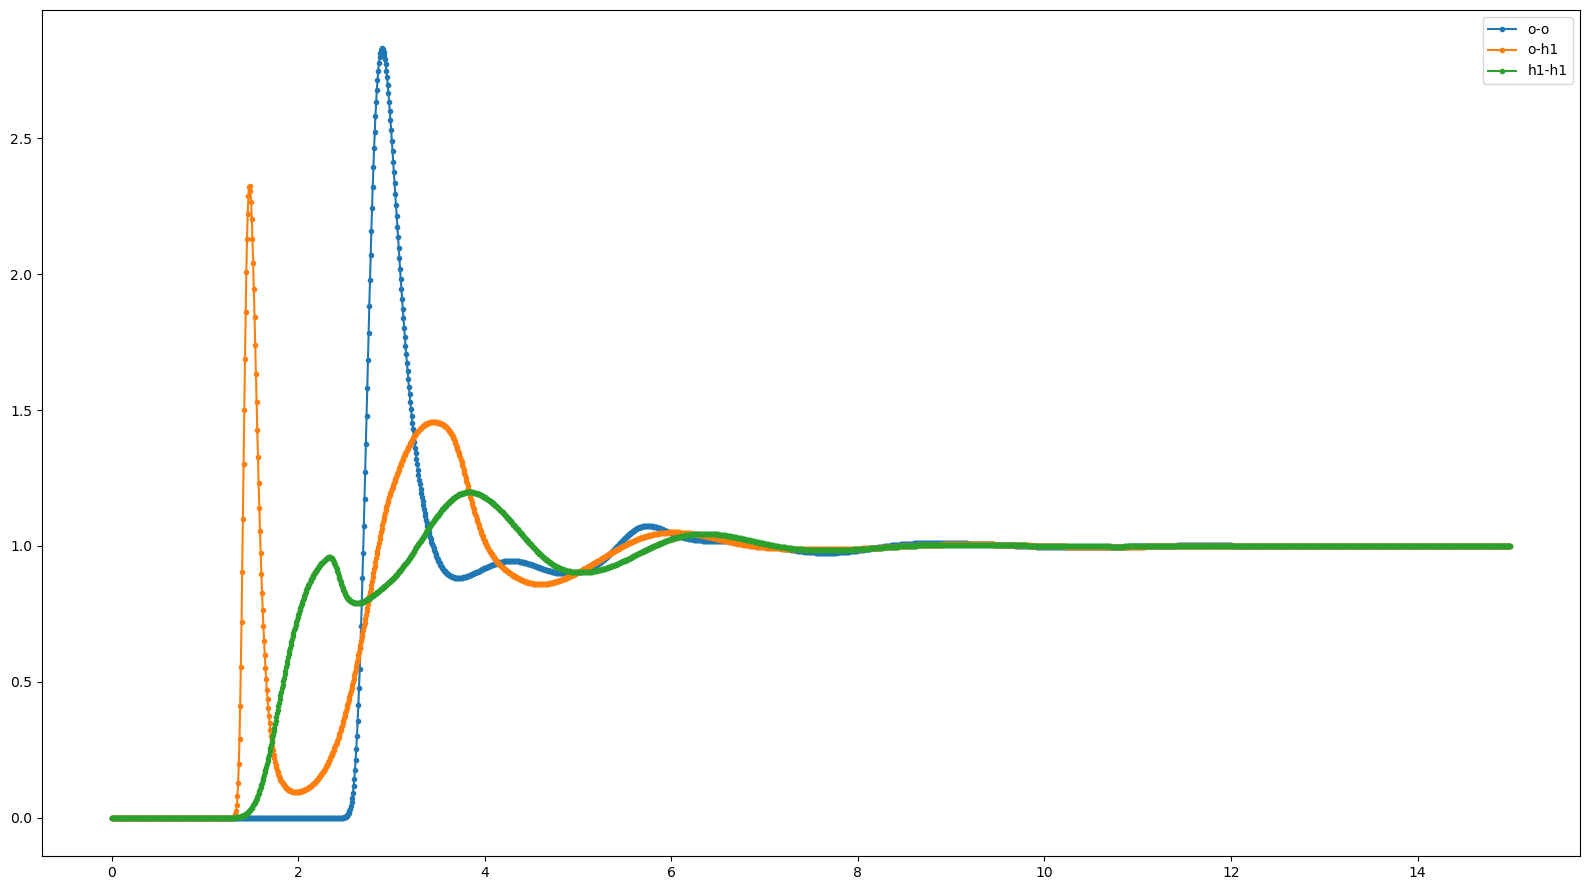

In [17]:
temperature = 300
grid = FFTGrid(r=[0, 15, 2048])
rho_b = Quantity(1.014, kilogram / decimeter**3) / Quantity(18, dalton) / NA
closure = rism.closure.hnc
solvent = get_solvent()

solver = RISMPolarSolventDIIS1DSolver(
    grid=grid,
    closure=closure,
    temperature=temperature,
    solvent=solvent,
    rho_b=rho_b,
    alpha=1.0,
)
print(solver._get_bond_length())
print(grid.zeros_field().shape)
h_matrix, c_matrix = solver.solve(max_iterations=1000, error_tolerance=1e-6)
visualize(grid, h_matrix + 1, solver.site_list)

In [13]:
matrix_file_path = '../data/tip3p_tcf.mat'
matrix = Matrix(grid, solvent.particle_list)
num_sites = len(solvent.particle_list)
for i in range(num_sites):
    for j in range(i, num_sites):
        matrix[i, j] = h_matrix[i, j]
        
writer = MatrixWriter(matrix_file_path)
writer.write(matrix)

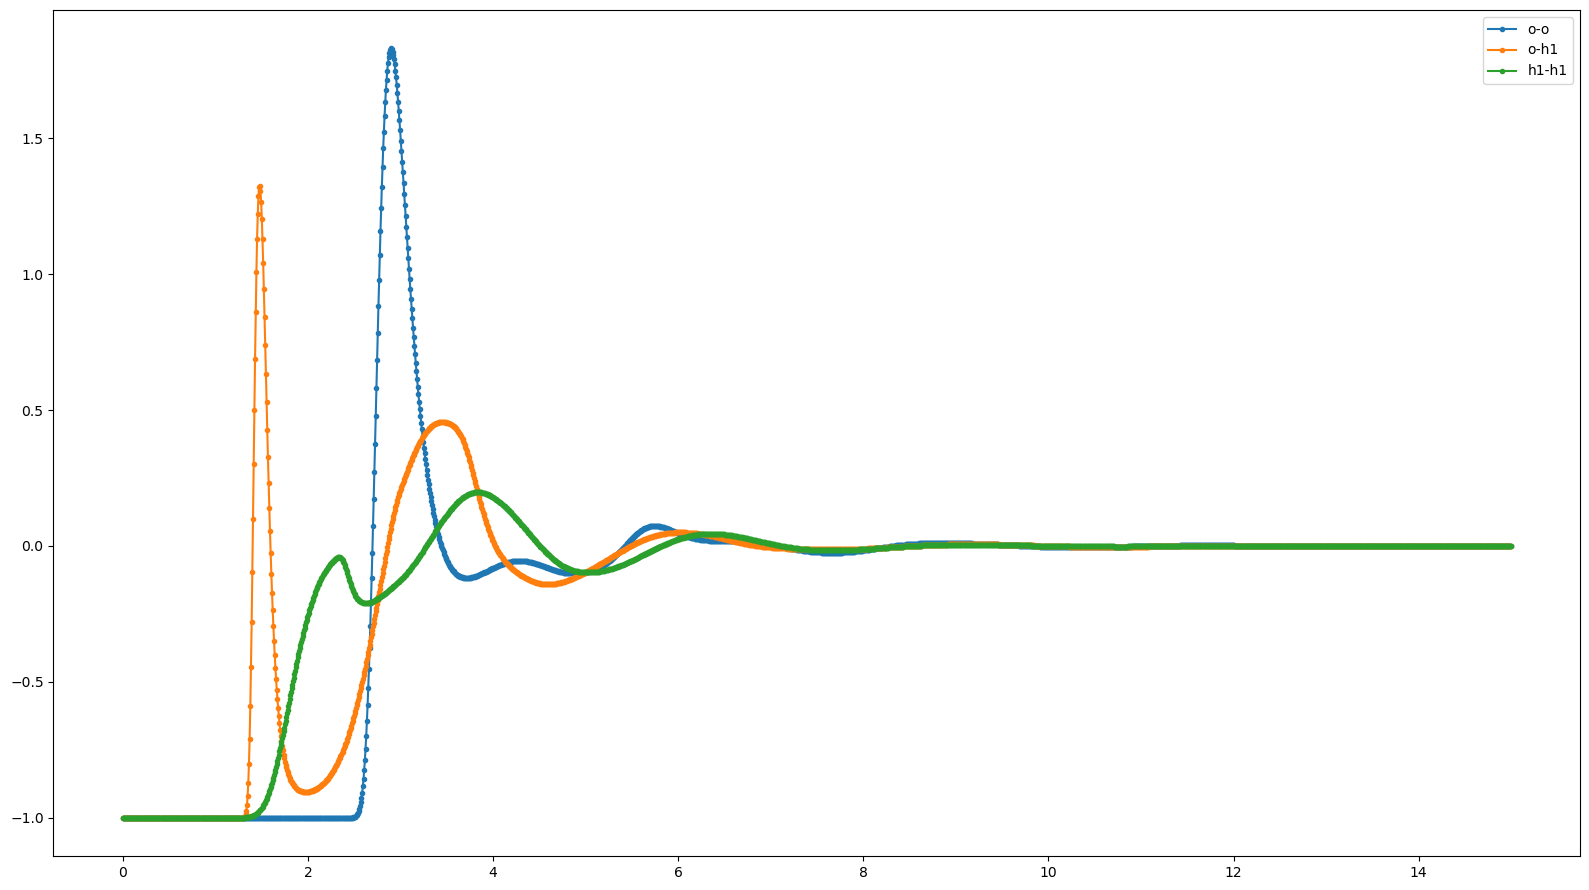

In [20]:
matrix = MatrixParser(matrix_file_path).parse()
visualize(matrix.grid, matrix, solver.site_list)